In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from data.utils import load_training_datasets
import os

# %env MLFLOW_TRACKING_URI /scratch/ag7531/mlruns

In [2]:
import xarray as xr
import numpy as np
import math

In [3]:
data_test=False #test with small batch, big batch needs .py to run

In [4]:
if data_test==True:
  raw_data = xr.open_zarr('/scratch/cimes/cz3321/MOM6/experiments/double_gyre/postprocess/offline_test/cm2p6/forcing.zarr')
  # raw_data = xr.open_zarr('/scratch/gpfs/cz3321/CM2P6/forcing.zarr') 
  raw_datasets = load_training_datasets(raw_data, 'training_subdomains.yaml')
else:
  # raw_data = xr.open_zarr('/scratch/cimes/cz3321/MOM6/experiments/double_gyre/postprocess/offline_test/cm2p6/forcing.zarr')
  raw_data = xr.open_zarr('/scratch/gpfs/cz3321/CM2P6/forcing.zarr')
  raw_datasets = load_training_datasets(raw_data, 'training_subdomains.yaml')

In [5]:
if data_test==False:
  first_dataset = raw_datasets[0]

  # #pick randomly
  # np.random.seed(42)
  # random_indices = np.random.choice(first_dataset.time.size, 1000, replace=False)

  #pick test dataset (20% in the end)
  start_index = int(first_dataset.time.size*0.8)
  random_indices = slice(start_index, None)

  random_snapshots = first_dataset.isel(time=random_indices)

In [6]:
if data_test==False:
  low_rez = random_snapshots
else:
  low_rez = raw_datasets[0]
u = low_rez['usurf']
v = low_rez['vsurf']
# u = prog['u'].fillna(0)

In [7]:
import torch
import importlib
#load the neural network
from torch.nn import Parameter
batch_norm = 0
def load_model_cls(model_module_name: str, model_cls_name: str):
    try:
        module = importlib.import_module(model_module_name)
        model_cls = getattr(module, model_cls_name)
    except ModuleNotFoundError as e:
        raise type(e)('Could not retrieve the module in which the trained model \
                      is defined: ' + str(e))
    except AttributeError as e:
        raise type(e)('Could not retrieve the model\'s class. ' + str(e))
    return model_cls
def load_paper_net(device: str = 'gpu'):
    """
        Load the neural network from the paper
    """
    print('In load_paper_net()')
    model_module_name = 'models.models1'
    model_cls_name = 'FullyCNN_BC'
    model_cls = load_model_cls(model_module_name, model_cls_name)
    print('After load_model_cls()')
    net = model_cls(2,4,batch_norm=batch_norm)
    
    # final_transform= '/scratch/cimes/cz3321/MOM6/MOM6-examples/src/MOM6/config_src/external/ML_Forpy/Forpy_CNN_GZ21/final_transformation_04292023.pth'
    # print('After net')
    # if device == 'cpu':
    #     transformation = torch.load(final_transform)
    #     print('After torch.load()')
    # else:
    #     transformation = pickle_artifact(MODEL_RUN_ID, 'models/transformation')
    # net.final_transformation = transformation
    print('After transformation')
    # Load parameters of pre-trained model
    print('After mlflow.tracking.MlflowClient()')
    
    
    # ----------------- CHANGE THIS PATH TO TRAINED MODEL ----------------- #
    model_file = '/scratch/cimes/cz3321/MOM6/MOM6-examples/src/MOM6/config_src/external/ML_Forpy/Forpy_CNN_GZ21/cem_7_four_regions_fixed_branch.pth'
    # ---------------------------------------------------- #
    
    
    print('Loading final transformation')
    model_module_name = 'models.transforms'
    model_cls_name1 = 'SoftPlusTransform'
    model_cls = load_model_cls(model_module_name, model_cls_name1)
    model_cls_name2 = 'PrecisionTransform'
    model_cls1 = load_model_cls(model_module_name, model_cls_name2)
    transform = model_cls.__new__(model_cls,)
    model_cls1.__init__(transform,)
    state_dict = torch.load(model_file, map_location=torch.device('cpu'))
    transform._min_value = Parameter(state_dict.pop('final_transformation._min_value'))
    transform.indices = slice(2,4)
    print('After download_artifacts()')
    #change the key name->
    print(model_cls_name)
    if model_cls_name.endswith("_BC"):
        from collections import OrderedDict
        if batch_norm == 1:
            keys_to_delete = ['2.num_batches_tracked', '5.num_batches_tracked', '8.num_batches_tracked', '11.num_batches_tracked', '14.num_batches_tracked', '17.num_batches_tracked', '20.num_batches_tracked']
            for key in keys_to_delete:
                if key in state_dict:
                    del state_dict[key]
            new_name=["conv1.weight", "conv1.bias", "batch_norm1.weight", "batch_norm1.bias", "batch_norm1.running_mean", "batch_norm1.running_var", "conv2.weight", "conv2.bias", "batch_norm2.weight", "batch_norm2.bias", "batch_norm2.running_mean", "batch_norm2.running_var", "conv3.weight", "conv3.bias", "batch_norm3.weight", "batch_norm3.bias", "batch_norm3.running_mean", "batch_norm3.running_var", "conv4.weight", "conv4.bias", "batch_norm4.weight", "batch_norm4.bias", "batch_norm4.running_mean", "batch_norm4.running_var", "conv5.weight", "conv5.bias", "batch_norm5.weight", "batch_norm5.bias", "batch_norm5.running_mean", "batch_norm5.running_var", "conv6.weight", "conv6.bias", "batch_norm6.weight", "batch_norm6.bias", "batch_norm6.running_mean", "batch_norm6.running_var", "conv7.weight", "conv7.bias", "batch_norm7.weight", "batch_norm7.bias", "batch_norm7.running_mean", "batch_norm7.running_var", "conv8.weight", "conv8.bias"]
        elif batch_norm == 0:
            new_name=["conv1.weight", "conv1.bias", "conv2.weight", "conv2.bias", "conv3.weight", "conv3.bias", "conv4.weight", "conv4.bias", "conv5.weight", "conv5.bias", "conv6.weight", "conv6.bias", "conv7.weight", "conv7.bias", "conv8.weight", "conv8.bias"]
        new_state_dict = OrderedDict()
        i=0
        for k, v in state_dict.items():
            name = new_name[i]
            new_state_dict[name] = v
            i = i+1
        state_dict = new_state_dict
    net.load_state_dict(state_dict)
    net.final_transformation = transform
    print(net)
    return net
matrix_dict = {}
net = load_paper_net('cpu')
net.eval()

In load_paper_net()
After load_model_cls()
After transformation
After mlflow.tracking.MlflowClient()
Loading final transformation
After download_artifacts()
FullyCNN_BC
FullyCNN_BC(
  (conv1): Conv2d(2, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv8): Conv2d(32, 4, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (final_transformation): SoftPlusTransform(tensor(0.0417, grad_fn=<SoftplusBackward>))
)


FullyCNN_BC(
  (conv1): Conv2d(2, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv8): Conv2d(32, 4, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (final_transformation): SoftPlusTransform(tensor(0.0417, grad_fn=<SoftplusBackward>))
)

In [8]:
device = torch.device('cpu')
from train.losses import HeteroskedasticGaussianLossV2

In [9]:
criterion = HeteroskedasticGaussianLossV2(n_target_channels=2)

In [10]:
from testing.utils_bc import (create_large_test_dataset, create_test_dataset)
from torch.utils.data import DataLoader

In [11]:
from data.datasets import (RawDataFromXrDataset, DatasetTransformer,
                           Subset_, DatasetWithTransform, ComposeTransforms,
                           MultipleTimeIndices, DatasetPartitioner)
low_rez = low_rez.fillna(0)
# low_rez = low_rez.isel(time=slice(0, 3))
dataset = RawDataFromXrDataset(low_rez * 10.)
dataset.index = 'time'
dataset.add_input('usurf')
dataset.add_input('vsurf')
dataset.add_landmask_input()
dataset.add_output('S_x')
dataset.add_output('S_y')
features_transform_ = ComposeTransforms()
targets_transform_ = ComposeTransforms()
transform = DatasetTransformer(features_transform_, targets_transform_)
transform.fit(dataset)
dataset = DatasetWithTransform(dataset, transform)

In [12]:
low_rez['S_x']=low_rez['S_x']*dataset.xr_dataset['landmask']
low_rez['S_y']=low_rez['S_y']*dataset.xr_dataset['landmask']

In [13]:
if data_test==True:
  test1 = create_large_test_dataset(net.to(device=device), criterion, [dataset, ], [DataLoader(dataset)], device,mask=False, replicate=False)
  test1 = test1.rename(dict(longitude='xu_ocean', latitude='yu_ocean'))
  test2 = create_large_test_dataset(net.to(device=device), criterion, [dataset, ], [DataLoader(dataset)], device,mask=True, replicate=False)
  test2 = test2.rename(dict(longitude='xu_ocean', latitude='yu_ocean'))
  test3 = create_large_test_dataset(net.to(device=device), criterion, [dataset, ], [DataLoader(dataset)], device,mask=True, replicate=True)
  test3 = test3.rename(dict(longitude='xu_ocean', latitude='yu_ocean'))

In [14]:
if data_test==True:
  from dask.diagnostics import ProgressBar
  with ProgressBar():
      test1 = test1.compute()
      test2 = test2.compute()
      test3 = test3.compute()
      # test3 = xr.open_dataset('test_four_regions_rpad.nc')
else:
   test1 = xr.open_dataset('test_four_regions_test7_nobc.nc')
   test2 = xr.open_dataset('test_four_regions_test7_0pad.nc')
   test3 = xr.open_dataset('test_four_regions_test7_rpad.nc')

In [15]:
def R2_snapshot(prediction, target):
  # return np.maximum(float(1 - (np.nanmean((target-prediction)**2)) / np.nanmean((target**2))),0)
  return np.maximum(1 - ((target-prediction)**2) / (target**2),0)
def MSE_snapshot(prediction, target):
  return (target-prediction)**2
def XSX_snapshot(prediction, target, velocity):
  return np.abs(velocity*target-velocity*prediction)

In [16]:
def R2(test, xlim=None, ylim=None):
    mask=dataset.isel(time=0)['landmask'].values
    maskn=np.where(mask == 0, torch.tensor(float('nan')), mask)
    mse = dict()
    variance = dict()
    r_squared = dict()
    R2_global = dict()
    # correlation = dict()
    for var in ['S_x', 'S_y']:
        mse[var] = ((test[var]*maskn - low_rez[var]*1e7*maskn)**2).mean(dim='time')
        variance[var] = ((low_rez[var]*1e7*maskn)**2).mean(dim='time')
        r_squared[var] = 1 - mse[var] / variance[var]
        R2_global[var] = 1 - np.nanmean(mse[var]) / np.nanmean(variance[var])
        # correlation[var] = xr.corr(test[var], low_rez[var]*1e7, dim='time')
    from matplotlib.patches import Arrow, Circle
    fig = plt.figure(figsize=(12,5))
    plt.rcParams.update({'font.size': 16})
    extent = (low_rez['xu_ocean'].min(), low_rez['xu_ocean'].max(), low_rez['yu_ocean'].min(), low_rez['yu_ocean'].max())
    xq = test['xu_ocean']
    yq = test['yu_ocean']
    for i, var in enumerate(['S_x', 'S_y']):
        plt.subplot(1, 2, i + 1)
        im = plt.imshow(r_squared[var], vmin=0., vmax=1,
                       origin='lower', extent=extent, aspect="auto")
        plt.xlim(xq[20],xq[-20])
        plt.ylim(yq[20],yq[-20])
        if xlim is not None:
            plt.xlim(xlim[0],xlim[1])
        if ylim is not None:
            plt.ylim(ylim[0],ylim[1])
        
        if i == 0:
            plt.ylabel('Latitude')
            patches = [Circle((11, 40), radius=0.4, color='white'),
                         Circle((18, 40), radius=0.4, color='green'),]
            for patch in patches:
                  im.axes.add_patch(patch)
            plt.title('(f) $R^2$ for $S_{x}^{(mean)}$:'+f' {round(R2_global[var],3)}')
        elif i == 1:
            patches = [Circle((11, 40), radius=0.4, color='white'),
                         Circle((18, 40), radius=0.4, color='green'),]
            for patch in patches:
                  im.axes.add_patch(patch)
            plt.title('(d) $R^2$ for $S_{y}^{(mean)}$:'+f' {round(R2_global[var],3)}')
        plt.xlabel('Longitude')

    
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.1, 0.025, 0.8])
    cbar = fig.colorbar(im, cax=cbar_ax, label=r'$R^2$')


KeyboardInterrupt



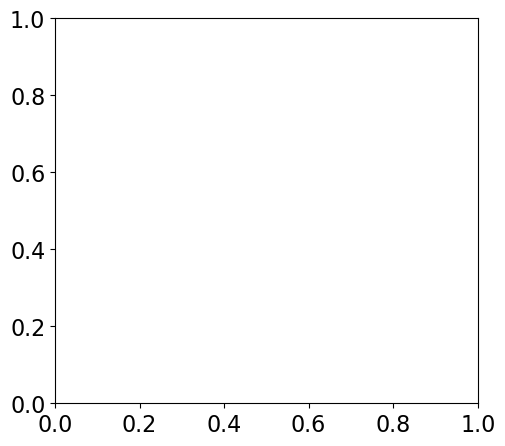

In [17]:
R2(test1)

In [ ]:
R2(test2)

In [ ]:
R2(test3)

In [18]:
from data.datasets import (RawDataFromXrDataset)
low_rez = low_rez.fillna(0)
# low_rez = low_rez.isel(time=slice(0, 3))
landmask = RawDataFromXrDataset(low_rez)
landmask.add_landmask_input(cnn_field_of_view=21)

In [19]:
def RMSE_timemean_log_plt(test,mask):
    fig, ax = plt.subplots(2, 1, figsize=(12,10))
    mask1=dataset.isel(time=0)['landmask'].values
    S_test = test['S_x']*(1e-7)*dataset.isel(time=0)['landmask']
    S_true = low_rez['S_x']*dataset.isel(time=0)['landmask']

    #Open water RMSE
    maskn=np.where(mask == 0, torch.tensor(float('nan')), mask)

    xq = test['xu_ocean']
    yq = test['yu_ocean']

    # MSE_OW = MSE_snapshot(S_test.mean(dim='time').values*maskn, S_true.mean(dim='time').values*maskn)
    RMSE_OW = np.sqrt(((S_test *maskn - S_true*maskn)**2).mean(dim='time'))
    RMSE_OW = np.where(RMSE_OW == 0, 1e-30, RMSE_OW)
    RMSE_OW_local = float(np.nanmean(RMSE_OW))
    p = ax[0].pcolormesh(xq,yq,np.log10(RMSE_OW), 
        vmin=-8, vmax = -6)
    
    # create Colormap
    colors = [ "gray","none"] 
    cmap = mcolors.ListedColormap(colors)
    bounds = [0, 0.5, 1]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    # use pcolormesh for landmask
    landmask_plot = ax[0].pcolormesh(xq, yq, mask1, cmap=cmap, norm=norm, shading='auto')

    # ax[0].set_xlabel('Longitude')
    ax[0].set_ylabel('Latitude')
    ax[0].set_title('(a) $S_{x}^{(mean)}$: true forcing')
    cbar = fig.colorbar(p, ax=ax[0],ticks=[-8, -7, -6], label='Subgrid forcing: $ms^{-2}$')
    cbar.ax.set_yticklabels(['$10^{-8}$', '$10^{-7}$', '$10^{-6}$'])

    ax[0].set_aspect('equal')
    ax[0].set_ylabel('Latitude')
    ax[0].set_title('(a) RMSE map for open water:'+f' {RMSE_OW_local:.3e}')

    ax[0].set_xlim(xq[20],xq[-20])
    ax[0].set_ylim(yq[20],yq[-20])

    #Coastal water RMSE
    maskn=np.where(mask == 1, torch.tensor(float('nan')), 1)
    mask1n=np.where(mask1 == 0, torch.tensor(float('nan')), mask1)
    maskn = mask1n*maskn

    # MSE_CW = MSE_snapshot(S_test.mean(dim='time').values*maskn, S_true.mean(dim='time').values*maskn)
    RMSE_CW = np.sqrt(((S_test *maskn - S_true*maskn)**2).mean(dim='time'))
    RMSE_CW = np.where(RMSE_CW == 0, 1e-30, RMSE_CW)
    RMSE_CW_local = float(np.nanmean(RMSE_CW))
    p = ax[1].pcolormesh(xq,yq,np.log10(RMSE_CW),  
        vmin=-8, vmax = -6)
    
    # create Colormap
    colors = [ "gray","none"] 
    cmap = mcolors.ListedColormap(colors)
    bounds = [0, 0.5, 1]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    # use pcolormesh for landmask
    landmask_plot = ax[1].pcolormesh(xq, yq, mask1, cmap=cmap, norm=norm, shading='auto')

    ax[1].set_aspect('equal')
    ax[1].set_xlabel('Longitude')
    ax[1].set_ylabel('Latitude')
    ax[1].set_title('(b) $S_{x}^{(mean)}$: true forcing')
    cbar = fig.colorbar(p, ax=ax[1],ticks=[-8, -7, -6], label='Subgrid forcing: $ms^{-2}$')
    cbar.ax.set_yticklabels(['$10^{-8}$', '$10^{-7}$', '$10^{-6}$'])
    
    ax[1].set_ylabel('Latitude')
    ax[1].set_title('(b) RMSE map for coastal water:'+f' {RMSE_CW_local:.3e}')

    ax[1].set_xlim(xq[20],xq[-20])
    ax[1].set_ylim(yq[20],yq[-20])

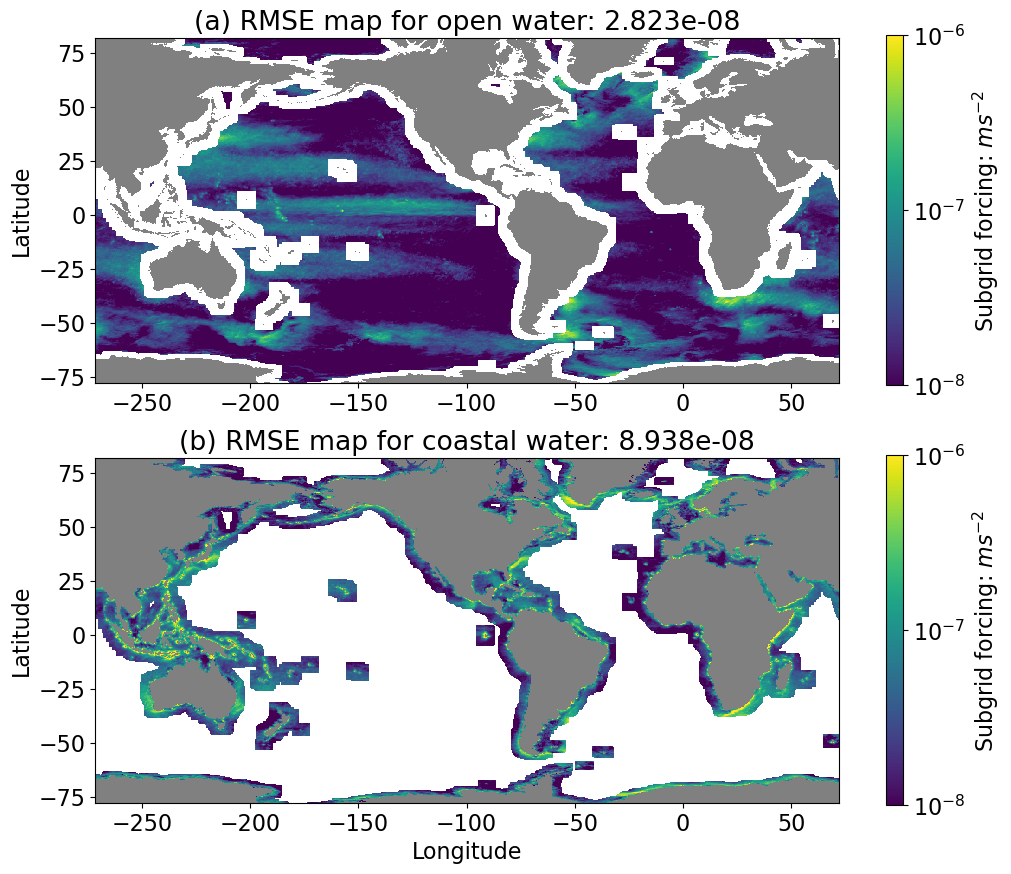

In [20]:
RMSE_timemean_log_plt(test1,mask=landmask.isel(time=0)['landmask'].values)

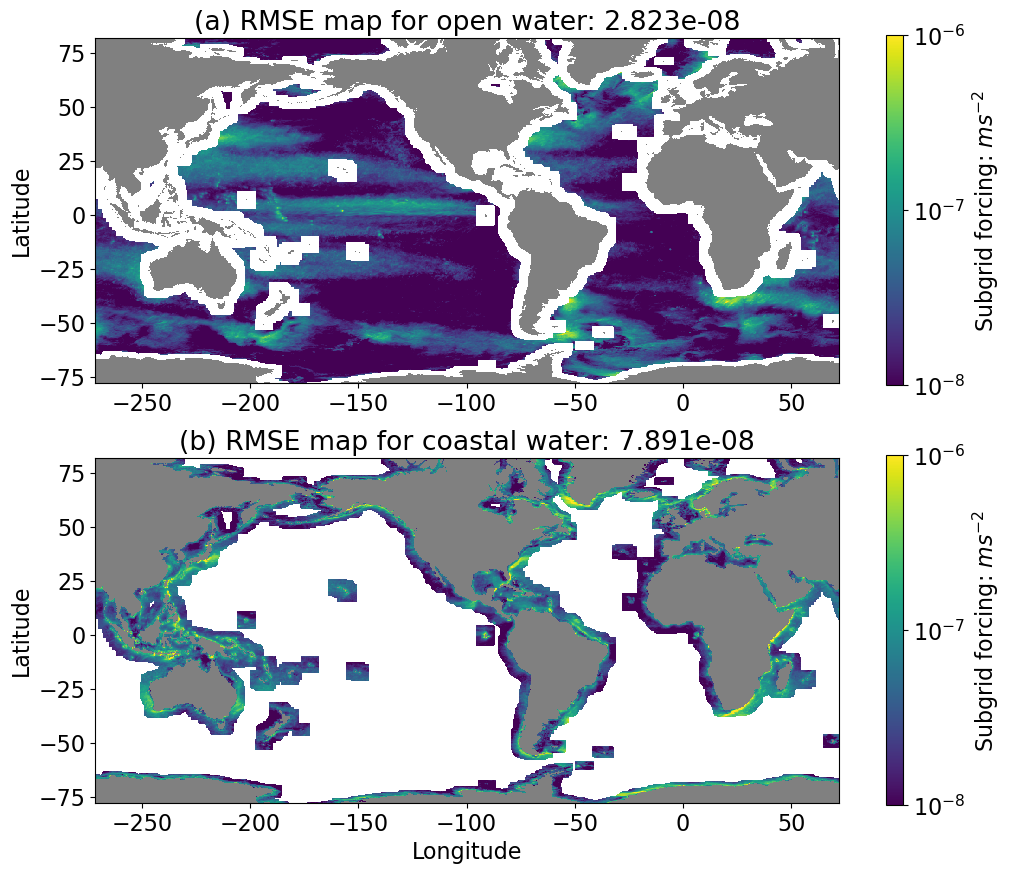

In [21]:
RMSE_timemean_log_plt(test2,mask=landmask.isel(time=0)['landmask'].values)

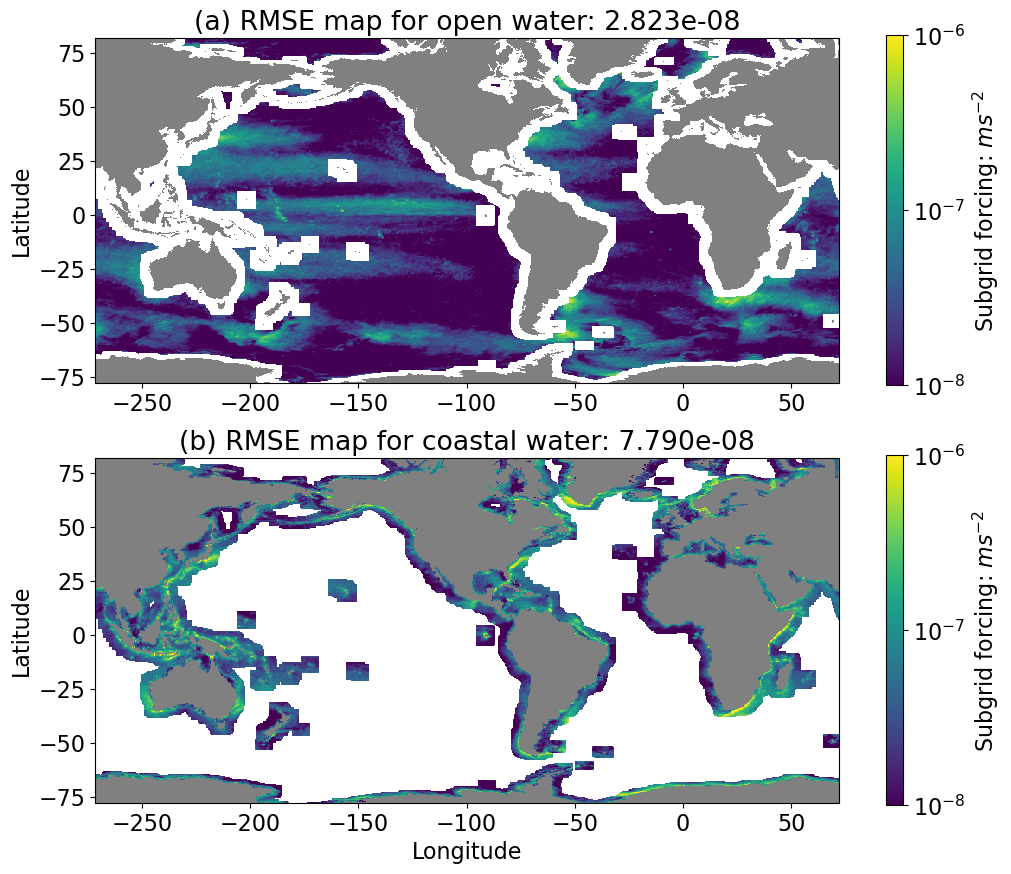

In [22]:
RMSE_timemean_log_plt(test3,mask=landmask.isel(time=0)['landmask'].values)

In [23]:
test1_0 = xr.open_dataset('test_four_regions_nobc.nc')
test2_0 = xr.open_dataset('test_four_regions_0pad.nc')
test3_0 = xr.open_dataset('test_four_regions_rpad.nc')

In [24]:
from matplotlib import patches 
def RMSD_timemean_diff_plt(test1_0,test2_0,test3_0,test1,test2,test3,mask, xlim=None, ylim=None,cbox1=None,cbox2=None):
    fig, ax = plt.subplots(3, 1, figsize=(12,15))
    plt.rcParams.update({'font.size': 14})
    mask1=dataset.isel(time=0)['landmask'].values
    S_test1 = test1['S_x']*(1e-7)*mask1
    S_test2 = test2['S_x']*(1e-7)*mask1
    S_test3 = test3['S_x']*(1e-7)*mask1
    S_test1_0 = test1_0['S_x']*(1e-7)*mask1
    S_test2_0 = test2_0['S_x']*(1e-7)*mask1
    S_test3_0 = test3_0['S_x']*(1e-7)*mask1
    # S_true = low_rez['S_x']

    xq = test1['xu_ocean']
    yq = test1['yu_ocean']

    # create Colormap
    colors = [ "gray","none"] 
    cmap = mcolors.ListedColormap(colors)
    bounds = [0, 0.5, 1]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)


    #Coastal water MSE
    maskn=np.where(mask == 1, torch.tensor(float('nan')), 1)
    mask1n=np.where(mask1 == 0, torch.tensor(float('nan')), mask1)
    maskn = mask1n*maskn

    MSE_CW1 = np.sqrt(((S_test1 *maskn - S_test1_0*maskn)**2).mean(dim='time'))
    MSE_CW1 = np.where(MSE_CW1 == 0, 1e-30, MSE_CW1)
    MSE_CW1_local = float(np.nanmean(MSE_CW1))
    p = ax[0].pcolormesh(xq,yq,np.log10(MSE_CW1), 
        vmin=-8, vmax = -6)
    # use pcolormesh for landmask
    ax[0].pcolormesh(xq, yq, mask1, cmap=cmap, norm=norm, shading='auto')

    # ax[0].set_xlabel('Longitude')
    ax[0].set_ylabel('Latitude')
    cbar = fig.colorbar(p, ax=ax[0],ticks=[-8, -7, -6], label='Subgrid forcing: $ms^{-2}$')
    cbar.ax.set_yticklabels(['$10^{-8}$', '$10^{-7}$', '$10^{-6}$'])
    
    ax[0].set_title('(a) RMSD map (no BC) for coastal water:'+f' {MSE_CW1_local:.3e}')
    ax[0].set_aspect('equal')

    if xlim is None:
        ax[0].set_xlim(xq[20],xq[-20])
        ax[0].set_ylim(yq[20],yq[-20])
    else:
        ax[0].set_xlim(xlim[0],xlim[1])
        ax[0].set_ylim(ylim[0],ylim[1])


    MSE_CW2 = np.sqrt(((S_test2 *maskn - S_test2_0*maskn)**2).mean(dim='time'))
    MSE_CW2 = np.where(MSE_CW2 == 0, 1e-30, MSE_CW2)
    MSE_CW2_local = float(np.nanmean(MSE_CW2))
    p = ax[1].pcolormesh(xq,yq,np.log10(MSE_CW2), 
        vmin=-8, vmax = -6)
    
    # use pcolormesh for landmask
    ax[1].pcolormesh(xq, yq, mask1, cmap=cmap, norm=norm, shading='auto')

    # ax[1].set_xlabel('Longitude')
    ax[1].set_ylabel('Latitude')
    cbar = fig.colorbar(p, ax=ax[1],ticks=[-8, -7, -6], label='Subgrid forcing: $ms^{-2}$')
    cbar.ax.set_yticklabels(['$10^{-8}$', '$10^{-7}$', '$10^{-6}$'])
    
    ax[1].set_title('(b) RMSD map (0P) for coastal water:'+f' {MSE_CW2_local:.3e}')
    ax[1].set_aspect('equal')

    if xlim is None:
        ax[1].set_xlim(xq[20],xq[-20])
        ax[1].set_ylim(yq[20],yq[-20])
    else:
        ax[1].set_xlim(xlim[0],xlim[1])
        ax[1].set_ylim(ylim[0],ylim[1])
    

    MSE_CW3 = np.sqrt(((S_test3 *maskn - S_test3_0*maskn)**2).mean(dim='time'))
    MSE_CW3 = np.where(MSE_CW3 == 0, 1e-30, MSE_CW3)
    MSE_CW3_local = float(np.nanmean(MSE_CW3))
    p = ax[2].pcolormesh(xq,yq,np.log10(MSE_CW3), 
        vmin=-8, vmax = -6)
    # use pcolormesh for landmask
    ax[2].pcolormesh(xq, yq, mask1, cmap=cmap, norm=norm, shading='auto')
    ax[2].set_xlabel('Longitude')
    ax[2].set_ylabel('Latitude')
    cbar = fig.colorbar(p, ax=ax[2],ticks=[-8, -7, -6], label='Subgrid forcing: $ms^{-2}$')
    cbar.ax.set_yticklabels(['$10^{-8}$', '$10^{-7}$', '$10^{-6}$'])
    
    ax[2].set_title('(b) RMSD map (RP) for coastal water:'+f' {MSE_CW3_local:.3e}')
    ax[2].set_aspect('equal')

    if xlim is None:
        ax[2].set_xlim(xq[20],xq[-20])
        ax[2].set_ylim(yq[20],yq[-20])
    else:
        ax[2].set_xlim(xlim[0],xlim[1])
        ax[2].set_ylim(ylim[0],ylim[1])

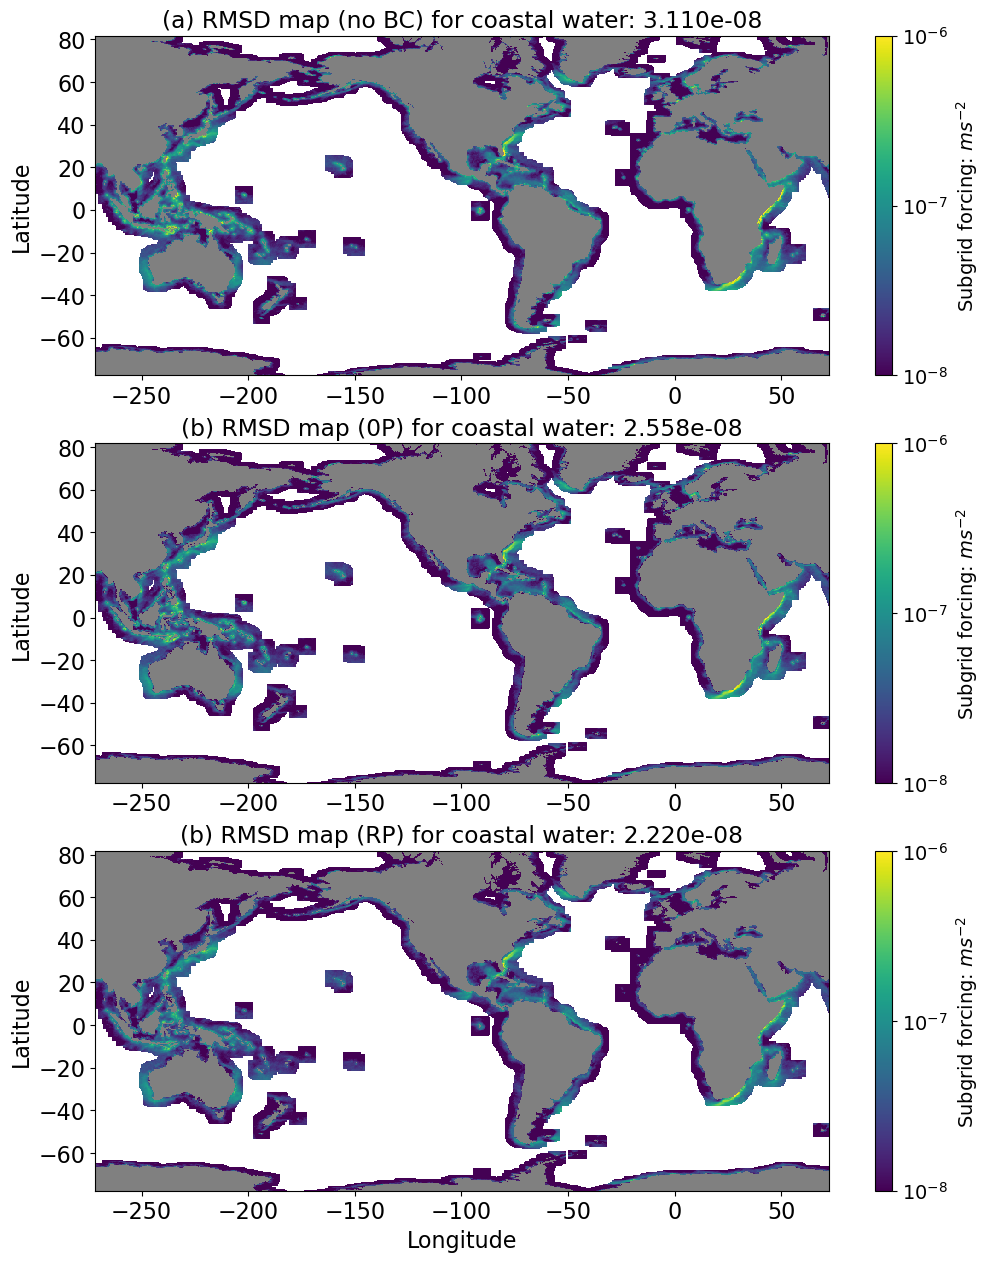

In [25]:
RMSD_timemean_diff_plt(test1_0,test2_0,test3_0,test1,test2,test3,mask=landmask.isel(time=0)['landmask'].values)